# Subradar Point over Apophis

Agustin Vallejo

In [2]:
import pandas as pd
import numpy as np

"MATPLOTLIB"
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pylab import cm

mpl.rcParams['font.family'] = 'Latin Modern Roman'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2

In [3]:
ephemeris = pd.read_csv("../ephemeris2.csv")
radio = pd.read_csv("../AllRadiotelescopes.csv")

# Astropy

In [4]:
"ASTROPY"
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun
from astropy.modeling.rotations import RotationSequence3D
from astropy.constants import c
import astropy.units as u

In [5]:
import warnings
warnings.simplefilter('ignore', UserWarning)

## Main Functions

In [6]:
# Obtains the Astropy Position Vector of given earth coordinates
pos = lambda x,h: EarthLocation(lon=x['Longitude']*u.deg,lat=x['Latitude']*u.deg,height=h*u.earthRad)

# Transforms an Astropy object into a simple 3-tuple vector
vec = lambda a:  (a.x.value,
                  a.y.value,
                  a.z.value)

# Returns the magnitude of a vector
dist = lambda v: np.linalg.norm(v)

# Returns the angle between two vectors in degrees
angle = lambda v1,v2: np.rad2deg( np.arccos( np.dot(v1,v2) / (dist(v1) * dist(v2)) ) )

def zenith_ecuat(obs, obs_time):
    """
    Obtains the coordinates of the observer's zenith at obs_time (jd)
    """
    zenith = SkyCoord(az=0*u.deg, alt=90*u.deg, distance=1*u.earthRad,
                      location=pos(obs,0), obstime=Time(obs_time, format='jd'), frame='altaz')
    return zenith.gcrs

def get_apo_to_earth(apo,obs,only_visible=True):
    """
    This function outputs the coordinates of an observatory as seen by Apophis.
    only_visible: If True, only returns points unobstructed by earth, invisible ones are None.
    If False, return all points.
    """
    # Apophis' coordinates
    apo_sky = SkyCoord(ra=apo['RA']*u.deg,dec=apo['DEC']*u.deg,
                       distance=apo['delta (Rt)']*u.earthRad)
    obs_time = Time(apo['datetime_jd'], format='jd')
    if (obs is None):
        apo_to_obs = SkyCoord(-apo_sky.cartesian, frame='gcrs', obstime=obs_time)
    else:
        obs_zenith = zenith_ecuat(obs, obs_time)
        # Dot product to determine if there's visibility:
        dot = np.dot(vec(apo_sky.cartesian),vec(obs_zenith.cartesian))
        if only_visible and dot < 0:
            return None
        apo_to_obs = SkyCoord(obs_zenith.cartesian - apo_sky.cartesian, frame='gcrs', obstime=obs_time)
    return apo_to_obs

def new_coordinates_matrix():
    """
    Generates a rotation matrix with respect to Apophís moment of intertia
    https://ned.ipac.caltech.edu/coordinate_calculator?in_csys=Ecliptic&in_equinox=J2000.0&obs_epoch=2000.0&lon=250&lat=-75&pa=0.0&out_csys=Equatorial&out_equinox=J2000.0
    https://www.aanda.org/articles/aa/pdf/2018/09/aa32914-18.pdf
    """
    # NEW Z AXIS
    new_z = SkyCoord(ra=118.79*u.deg,dec=-79.4*u.deg,
                       distance=1*u.earthRad)
    new_z = vec(new_z.cartesian)
    new_z /= np.linalg.norm(new_z)

    # NEW X AXIS
    new_x = SkyCoord(ra=0*u.deg,dec=0*u.deg,
                       distance=1*u.earthRad)
    new_x = vec(new_x.cartesian)
    new_x = np.cross(new_z,new_x)
    new_x /= np.linalg.norm(new_x)

    # NEW Y AXIS
    new_y = np.cross(new_z,new_x)
    new_y /= np.linalg.norm(new_y)

    ROT = np.matrix([new_x,new_y,new_z])
    return ROT

def to_asteroid_coordinates(v_gcrs,t):
    """
    Gets a vector in gcrs representation and generates the
    Asteroid local coordinates for a given time t.

    Asteroid coordinates are based on the axis of rotation.
    """
    v_subradar = to_subradar_coordinates(v_gcrs)
    v_subradar_rotated = rotate_asteroid(v_subradar,t)
    return v_subradar_rotated

def to_subradar_coordinates(v_gcrs):
    """
    Gets a vector in gcrs representation and generates the
    Asteroid local coordinates for a time 0.
    """
    ROT = new_coordinates_matrix()
    v_subradar = np.matmul(ROT,vec(v_gcrs.cartesian))
    v_subradar = np.array(v_subradar).flatten()
    return SkyCoord(*v_subradar,representation_type='cartesian').gcrs

def rotate_asteroid(v_subradar,t):
    ROT = rotation_matrix(t)
    v_subradar_rotated = np.matmul(ROT,vec(v_subradar.cartesian))
    v_subradar_rotated = np.array(v_subradar_rotated).flatten()
    return SkyCoord(*v_subradar_rotated,representation_type='cartesian').gcrs

def rotation_matrix(t):
    omega = 2*np.pi/(27.38/24)
    theta = omega*t - 0.5967
    ROT = np.matrix([[np.cos(theta),np.sin(theta),0],
                     [-np.sin(theta),np.cos(theta),0],
                     [0,0,1]])
    return ROT

def get_subradar_points(ephemeris,obs,only_visible=True):
    """
    This function iterates over the ephemeris to generate subradar points 
    for a specific observatory
    """
    output = {"date":[],
              "date_jd": [],
              "ra":[],
              "dec":[],
              "lon":[],
              "lat":[],
              "latR":[],
              "lonR":[],
              "dist":[]}

    date0 = ephemeris['datetime_jd'][ephemeris['delta (Rt)'].idxmin()]
    for r,row in ephemeris.iterrows():
        point = get_apo_to_earth(row,obs,only_visible)
        if point:
            point_sub = to_subradar_coordinates(point)
            output['date'] += [row['datetime_str']]
            output['date_jd'] += [row['datetime_jd']]

            # ECUATORIAL COORDINATES OF OBSERVATORY FROM APOPHIS
            output['ra']   += [point.ra.value]
            output['dec']  += [point.dec.value]

            # LOCAL COORDINATES OF OBS FROM APOPHIS
            output['lat']  += [point_sub.dec.value]
            if point_sub.ra.value < 180:
                output['lon'] += [point_sub.ra.value]
            else:
                output['lon'] += [point_sub.ra.value - 360]

            # LOCAL COORDINATES OF OBS FROM APOPHIS APPLYING ROTATION
            t = row['datetime_jd'] - date0
            point_sub_rotated = rotate_asteroid(point_sub,t)
            output['latR']  += [point_sub_rotated.dec.value]
            if point_sub_rotated.ra.value < 180:
                output['lonR'] += [point_sub_rotated.ra.value]
            else:
                output['lonR'] += [point_sub_rotated.ra.value - 360]

            output['dist'] += [row['delta (Rt)']]
    return output

In [7]:
# TEST CELL OF COORDINATE TRANSFORMATION
point = SkyCoord(ra=118.79*u.deg,dec=-79.4*u.deg,
                       distance=1*u.earthRad) # THIS IN PARTICULAR IS THE POINTING VECTOR OF THE ASTEROID MOMENT OF INERTIA
MIN = ephemeris['delta (Rt)'].argmin()
to_subradar_coordinates(point) # Should have a latitude close to 90°

<SkyCoord (GCRS: obstime=J2000.000, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec) in deg
    (189.57750355, 89.99422692)>

## Subradar Points

In [8]:
radio.Name

0              Canberra DSS-43
1                       Parkes
2                Madrid DSS-63
3                       Lovell
4                   Effelsberg
5                    AVN-Ghana
6                    Goldstone
7                   Green Bank
8             Very Large Array
9                    Arecibo 2
10                        FAST
11               Galenki RT-70
12    Usuda Deep Space Center 
Name: Name, dtype: object

In [9]:
obs = radio.iloc[3]
obs = {'Name':"Earth's Center"}
subradar_points = pd.DataFrame(get_subradar_points(ephemeris,None))
# subradar_points.to_csv("../Data/subradar_points.csv")

In [10]:
subradar_points

,date,date_jd,ra,dec,lon,lat,latR,lonR,dist
0,2029-Apr-13 13:30,2462240.063,20.17701,23.94602,-114.590194,-25.094418,-25.097121,27.836864,30.165656
1,2029-Apr-13 13:35,2462240.066,20.05465,23.87547,-114.453582,-25.047769,-25.050478,27.026713,29.882975
2,2029-Apr-13 13:40,2462240.069,19.93009,23.80346,-114.314466,-25.000088,-25.002803,26.219067,29.600302
3,2029-Apr-13 13:45,2462240.073,19.80327,23.72997,-114.172780,-24.951365,-24.954090,25.098397,29.317638
4,2029-Apr-13 13:50,2462240.076,19.67413,23.65493,-114.028450,-24.901544,-24.904272,24.295964,29.034985
...,...,...,...,...,...,...,...,...,...
195,2029-Apr-14 05:45,2462240.740,201.52165,-24.70663,63.922720,25.594497,25.596508,-7.287385,29.310575
196,2029-Apr-14 05:50,2462240.743,201.39295,-24.63440,64.065894,25.547406,25.549403,-8.090972,29.593250
197,2029-Apr-14 05:55,2462240.747,201.26684,-24.56342,64.206241,25.501060,25.503037,-9.212978,29.875936
198,2029-Apr-14 06:00,2462240.750,201.14323,-24.49367,64.343855,25.455454,25.457416,-10.022126,30.158631


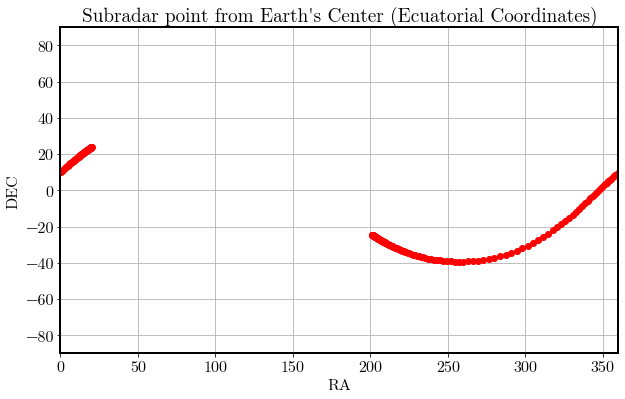

In [11]:
plt.figure(figsize=(10,6))
# plt.plot(180+ephemeris['RA'],-1*ephemeris['DEC'],'bo',label="Ecuatorial Coordinates of Earth from Apophis")
plt.plot(subradar_points.ra,subradar_points.dec,'ro',label="Ecuatorial Coordinates of Observatory from Apophis")
plt.xlim([0,360])
plt.ylim([-90,90])
# plt.legend()
plt.title("Subradar point from "+obs['Name'] + " (Ecuatorial Coordinates)")
plt.xlabel("RA")
plt.ylabel("DEC")
plt.grid()

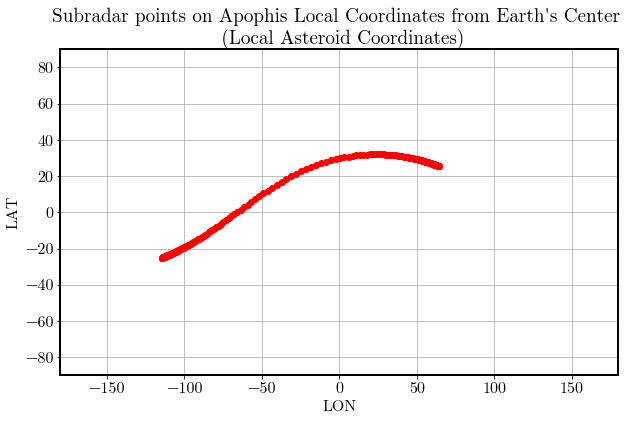

In [12]:
plt.figure(figsize=(10,6))
plt.plot(subradar_points.lon,subradar_points.lat,'ro')
plt.xlim([-180,180])
plt.ylim([-90,90])
plt.title("Subradar points on Apophis Local Coordinates from "+obs['Name']+" \n (Local Asteroid Coordinates)")
plt.xlabel("LON")
plt.ylabel("LAT")
plt.grid()

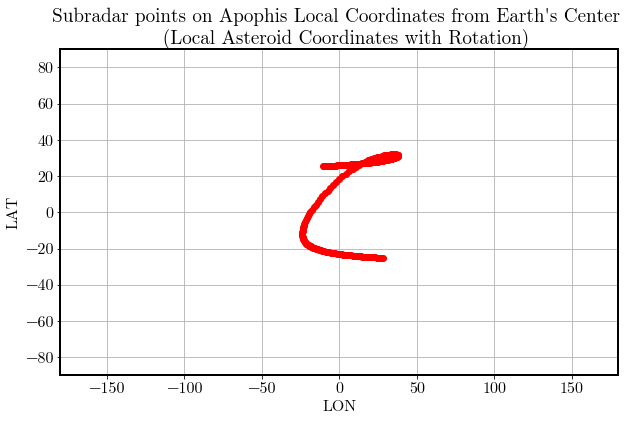

In [13]:
plt.figure(figsize=(10,6))
plt.plot(subradar_points.lonR,subradar_points.latR,'ro')
plt.xlim([-180,180])
plt.ylim([-90,90])
plt.title("Subradar points on Apophis Local Coordinates from "+obs['Name']+" \n  (Local Asteroid Coordinates with Rotation)")
plt.xlabel("LON")
plt.ylabel("LAT")
plt.grid()

## Surface Coverage

In [14]:
def path(ax):
    ax.plot(np.deg2rad(subradar_points.lonR),np.deg2rad(subradar_points.latR),'ko',ms=7)
    ax.plot(np.deg2rad(subradar_points.lonR),np.deg2rad(subradar_points.latR),'wo',ms=6)

def earth(ax,t):
    ax.plot(np.deg2rad(subradar_points.lonR[t]),np.deg2rad(subradar_points.latR[t]),'bo',ms=17)
    ax.plot(np.deg2rad(subradar_points.lonR[t]),np.deg2rad(subradar_points.latR[t]),'wo',ms=12)
    ax.plot(np.deg2rad(subradar_points.lonR[t]),np.deg2rad(subradar_points.latR[t]),'b_',ms=17)
    ax.plot(np.deg2rad(subradar_points.lonR[t]),np.deg2rad(subradar_points.latR[t]),'b|',ms=17)

In [15]:
subradar_points = pd.DataFrame(get_subradar_points(ephemeris,None))

In [16]:
# Given longitude and latitude angles in degrees, return cartesian representation
spherical = lambda lon,lat: (np.cos(np.deg2rad(lon))*np.cos(np.deg2rad(lat)),
                             np.sin(np.deg2rad(lon))*np.cos(np.deg2rad(lat)),
                             np.sin(np.deg2rad(lat)))

sphericalV = lambda lon,lat: (np.sin(np.deg2rad(lon))*np.cos(np.deg2rad(lat))*-1,
                              np.cos(np.deg2rad(lon))*np.cos(np.deg2rad(lat)),
                              0*lon)

N_lons = 72
N_lats = 36
lons   = np.linspace(-180,180,N_lons)
lats   = np.linspace(-90,90,N_lats)

lon_grid, lat_grid = np.meshgrid(lons, lats)

def coverage(point):
    """
    Returns the meshgrid of all the radar coverage
    """
    out = np.zeros((N_lats,N_lons))
    dot = np.tensordot(spherical(point.lonR, point.latR),
                    spherical(lon_grid, lat_grid), axes=1)
    out[dot > 0] = 1
    return out

def full_coverage(subradar_points):
    out = np.zeros((N_lats,N_lons))
    for r, point in subradar_points.iterrows():
        out += coverage(point)
    out /= np.max(out)
    return out

def radial_coverage(point):
    """
    Returns the meshgrid of all the radar coverage
    """
    out = coverage(point)
    dotV = np.tensordot(spherical(point.lonR, point.latR),
                sphericalV(lon_grid, lat_grid), axes=1)
    return out*dotV*20 # 1e-3 m/s

def minmax(arr):
    arrmax = np.max(arr,axis=0)
    arrmin = np.min(arr,axis=0)

    out = arrmax
    out[arrmax < np.abs(arrmin)] = arrmin[arrmax < np.abs(arrmin)]

    return out

MIN = subradar_points['dist'].argmin()

def full_coverage_radial(subradar_points):
    out = np.zeros((len(ephemeris),N_lats,N_lons))
    for r, point in subradar_points.iterrows():
        out[r] = radial_coverage(point)
    out = minmax(out)
    # out = np.max(out,axis=0) - np.min(out,axis=0)
    # out = out[MIN]
    return out

full_cov_all = full_coverage_radial(subradar_points)
full_cov = np.mean(full_cov_all)

TypeError: Input z must be 2D, not 0D

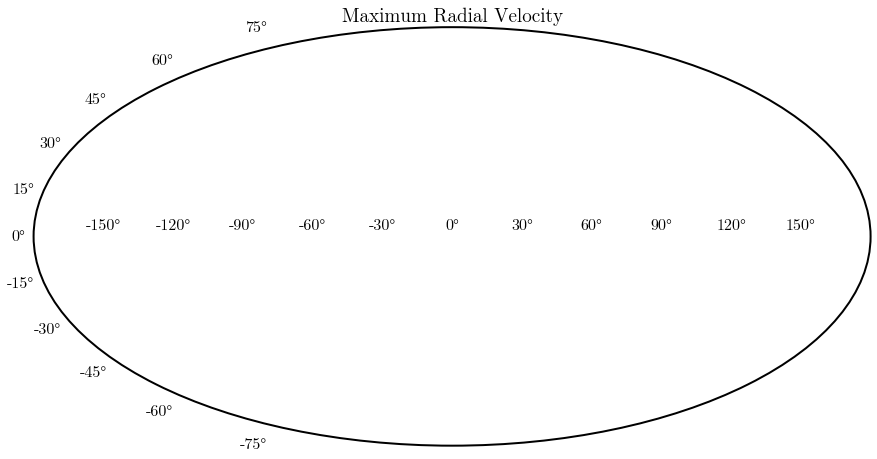

In [17]:

fig = plt.figure(figsize=(15,8))
ax = plt.subplot(111, projection = 'mollweide')
ax.set_title("Maximum Radial Velocity")
axx = ax.contourf(np.deg2rad(lons), np.deg2rad(lats), full_cov, cmap="RdBu", levels=100)
earth(ax,MIN)
ax.grid()
fig.colorbar(axx,ax=ax, label=r"Radial Velocity [$\times 10^{-3}$ m/s]")


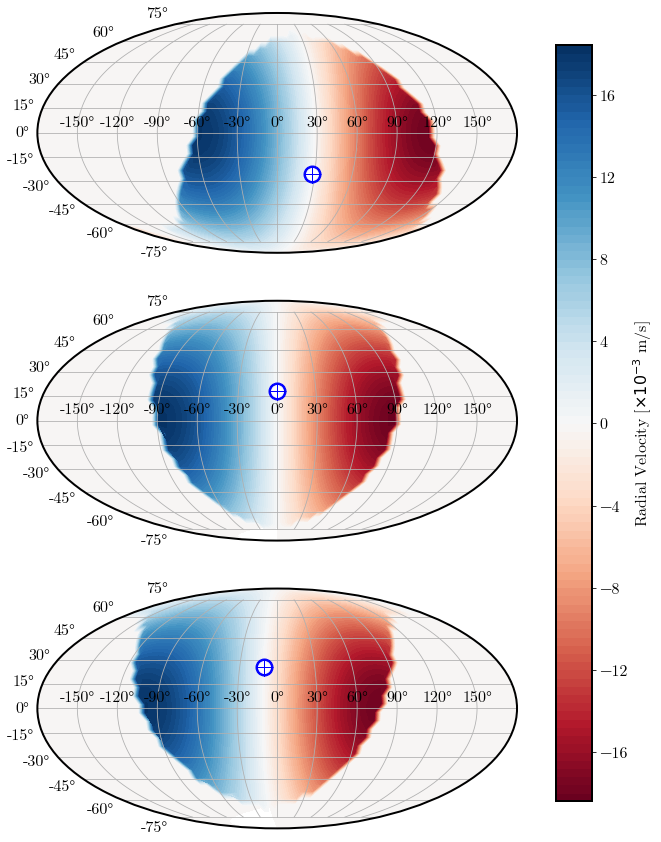

In [ ]:
fig = plt.figure(figsize=(10,15))

for i,t in enumerate([0,MIN,199]):
    full_cov = full_cov_all[t]
    ax = plt.subplot(3,1,i+1, projection = 'mollweide')
    axx = ax.contourf(np.deg2rad(lons), np.deg2rad(lats), full_cov, cmap="RdBu", levels=100)
    earth(ax,t)
    ax.grid()
    
# fig.colorbar(axx,ax=ax, label=r"Radial Velocity [$\times 10^{-3}$ m/s]", orientation="horizontal")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(axx, cax=cbar_ax, label=r"Radial Velocity [$\times 10^{-3}$ m/s]") #, orientation="horizontal")


In [ ]:
total_time = (ephemeris['datetime_jd'].iloc[-1]-ephemeris['datetime_jd'].iloc[0])*u.day.to(u.h)
total_time

full_cov_h = full_cov#*total_time

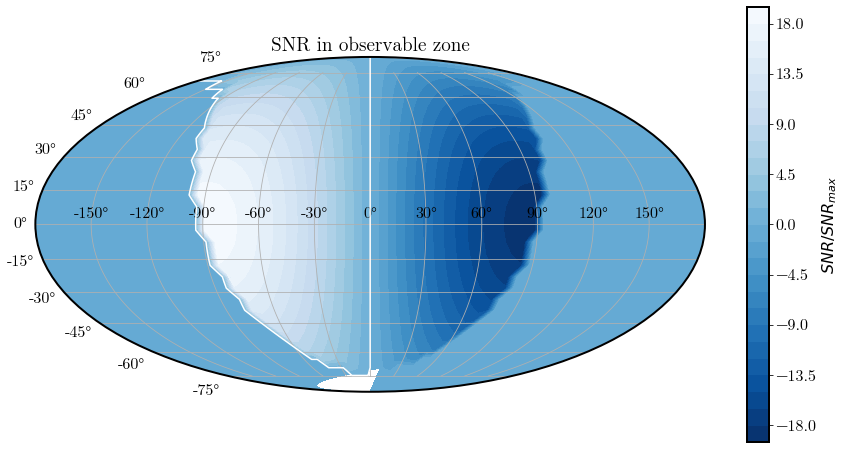

In [ ]:
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(111, projection = 'mollweide')
ax.set_title("SNR in observable zone")
axx = ax.contourf(np.deg2rad(lons), np.deg2rad(lats), full_cov, cmap="Blues_r", levels=30)
axx1 = ax.contour(np.deg2rad(lons), np.deg2rad(lats), full_cov,linestyle='dashed',levels=0, colors='white')
ax.grid()
# fig.colorbar(axx1,ax=ax)#, label="Visibility time [h]")
fig.colorbar(axx,ax=ax, label=r"$SNR/SNR_{max}$")

# name = "../Figures/fig11_snr"
# plt.savefig(name+".pdf",bbox_inches='tight')
# plt.savefig(name+".png",bbox_inches='tight')

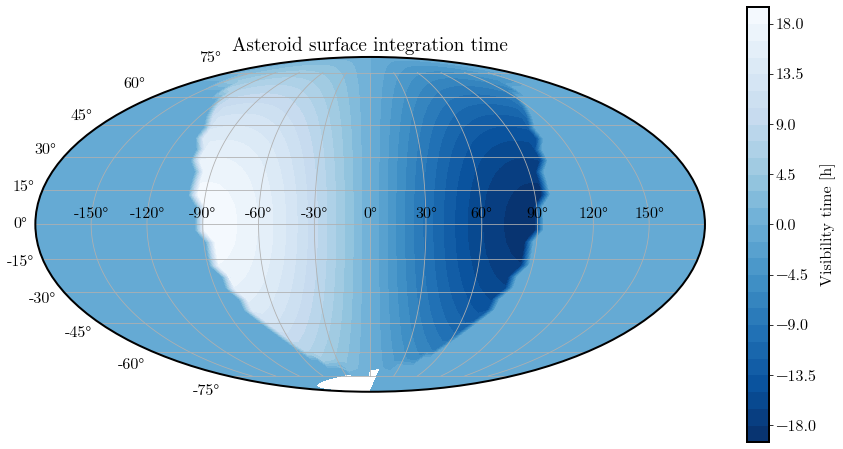

In [ ]:
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(111, projection = 'mollweide')
ax.set_title("Asteroid surface integration time")
axx = ax.contourf(np.deg2rad(lons), np.deg2rad(lats), full_cov_h, cmap="Blues_r", levels=30)
ax.grid()
fig.colorbar(axx,ax=ax, label="Visibility time [h]")

In [ ]:
threshold = 1/60 # h
covered = lambda x: 1 if x>threshold else x/threshold

integrable = np.vectorize(covered)(full_cov_h)

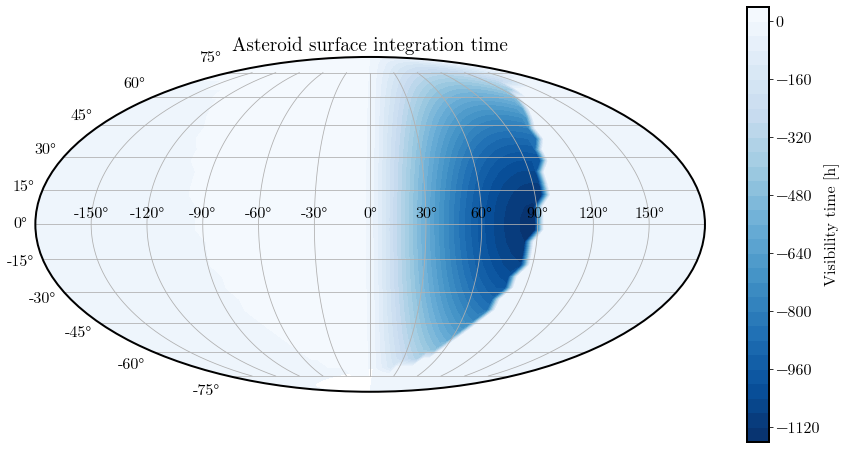

In [ ]:
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(111, projection = 'mollweide')
ax.set_title("Asteroid surface integration time")
axx = ax.contourf(np.deg2rad(lons), np.deg2rad(lats), integrable, cmap="Blues_r", levels=30)
# ax.colorbar()
ax.grid()
fig.colorbar(axx,ax=ax, label="Visibility time [h]")
# ax.savefig("Radio coverage %s.png"%obs['Name'])

In [ ]:
len(subradar_points)

200

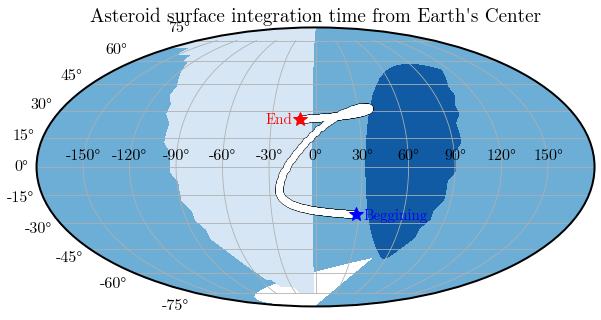

In [ ]:
plt.figure(figsize=(10,6))
ax = plt.subplot(111, projection = 'mollweide')
ax.set_title("Asteroid surface integration time from "+obs['Name'])
axx = ax.contourf(np.deg2rad(lons), np.deg2rad(lats), integrable, cmap="Blues_r", levels=1)



last = len(subradar_points) - 1
ax.plot(np.deg2rad(subradar_points.lonR[0]),np.deg2rad(subradar_points.latR[0]),'b*',ms=15)
ax.plot(np.deg2rad(subradar_points.lonR[last]),np.deg2rad(subradar_points.latR[last]),'r*',ms=15)
ax.text(np.deg2rad(subradar_points.lonR[0])+0.1,np.deg2rad(subradar_points.latR[0])-0.05,"Beggining",color="blue", size=15)
ax.text(np.deg2rad(subradar_points.lonR[last])-0.4,np.deg2rad(subradar_points.latR[last])-0.05,"End",color="red",size=15)
# ax.colorbar()
ax.grid()
# ax.savefig("Radio coverage %s.png"%obs['Name'])

In [ ]:
# subradar_points.to_csv("subradar_points.csv")

## Surface Coverage using All

In [ ]:
radio.Code

plan = ['PRK','AVN','GBT','FAS']

plan = [radio[radio.Code == a].iloc[0] for a in plan]

In [ ]:
all_integrable = np.zeros((N_lats,N_lons))

for obs in plan:
    subradar_points = pd.DataFrame(get_subradar_points(ephemeris,obs))
    full_cov = full_coverage(subradar_points)
    # full_cov_h = full_cov_norm*total_time
    # integrable = np.vectorize(covered)(full_cov_h)
    all_integrable += full_cov

subradar_points = pd.DataFrame(get_subradar_points(ephemeris,None))


'lmroman10-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


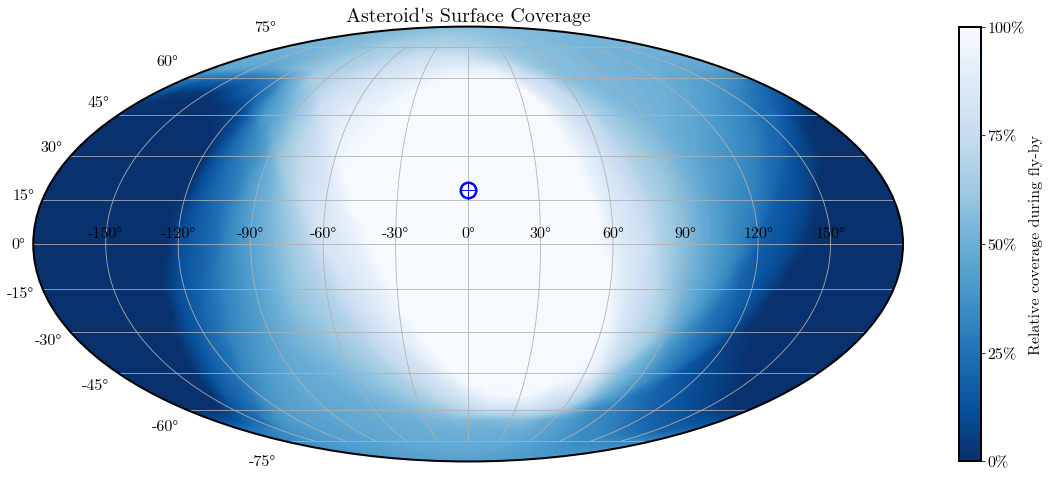

In [ ]:
fig = plt.figure(figsize=(20,8))
ax = plt.subplot(111, projection = 'mollweide')
ax.set_title("Asteroid's Surface Coverage",size=20)
axx = ax.contourf(np.deg2rad(lons), np.deg2rad(lats), all_integrable/4, cmap="Blues_r", levels=100)

# ax.plot(np.deg2rad(subradar_points.lonR),np.deg2rad(subradar_points.latR),'ko',ms=7)
# ax.plot(np.deg2rad(subradar_points.lonR),np.deg2rad(subradar_points.latR),'wo',ms=6)

ax.plot(np.deg2rad(subradar_points.lonR[MIN]),np.deg2rad(subradar_points.latR[MIN]),'bo',ms=17)
ax.plot(np.deg2rad(subradar_points.lonR[MIN]),np.deg2rad(subradar_points.latR[MIN]),'wo',ms=12)
ax.plot(np.deg2rad(subradar_points.lonR[MIN]),np.deg2rad(subradar_points.latR[MIN]),'b_',ms=17)
ax.plot(np.deg2rad(subradar_points.lonR[MIN]),np.deg2rad(subradar_points.latR[MIN]),'b|',ms=17)
ax.grid()

cbar = fig.colorbar(axx, label="Relative coverage during fly-by")
cbar.set_ticks([0, .25, .5, .75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])

name = "../Figures/fig10_coverage"
plt.savefig(name+".pdf",bbox_inches='tight')
plt.savefig(name+".png",bbox_inches='tight')

1.0 0.8614969135802469
0.7561728395061729 0.7561728395061729
0.49614197530864196 0.49614197530864196
0.23996913580246915 0.23996913580246915
0.13734567901234568 0.0
2592
2233


(array([444., 130., 109., 166., 457., 460., 160., 106., 114., 446.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

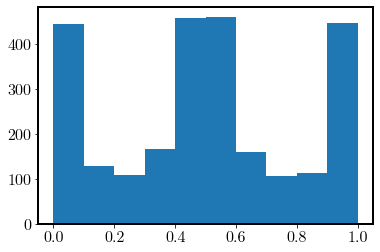

In [ ]:
counts = all_integrable.flatten()
# plt.plot(np.sort(counts))
for k in [0,.25,.5,.75,1]:
    print(len(counts[counts>=4*k])/len(counts),end=' ')
    print(len(counts[counts>4*k])/len(counts))
print(len(counts))
print(np.count_nonzero(counts))
plt.hist(counts/4)